## Smart Beta Portfolio Optimization

A Smart Beta Portfolio aims to improve upon traditional market-capitalization-weighted indexing by using alternative weighting strategies. Instead of simply following the market, it relies on certain factors or fundamentals, such as dividends or trading volumes, to determine the weights of the stocks in the portfolio. This approach seeks to provide better risk-adjusted returns. Using the cvxpy library, the we perform a quadratic optimization to minimize the portfolio variance while keeping the weights close to the initial benchmark weights. Logically, this involves solving an optimization problem with constraints that the weights must be non-negative and sum up to 1. Then, it periodically rebalances the portfolio to optimize returns while managing risks.

In [ ]:
# This code was modified based on a previous contribution from Abdelkarim Abdallah

# Let’s look at the 5Y Portfolio 2 of 10 stocks
# Fetch the data
tickers = ['TSLA', 'NVDA', 'AAPL', 'AMZN', 'MSFT', 'GOOGL', 'META', 'NFLX', 'BRK-B', 'JNJ']
years = 5

In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# Part 1: Fetching Stock Data
def fetch_stock_data(ticker_list, years=5):
    # Define the date range for fetching data
    end_date = datetime.now()
    start_date = end_date - timedelta(days=years * 365)

    # Initialize empty DataFrames for close, volume, and dividends data
    close_data_df = pd.DataFrame()
    volume_data_df = pd.DataFrame()
    dividends_data_df = pd.DataFrame()

    # Loop through each ticker and fetch its historical data
    for ticker in ticker_list:
        stock = yf.Ticker(ticker)
        hist_data = stock.history(period='1d', start=start_date, end=end_date)

        # Close Data
        close_data = hist_data['Close'].rename(ticker)
        close_data_df = pd.merge(close_data_df, pd.DataFrame(close_data), left_index=True, right_index=True, how='outer')

        # Volume Data
        volume_data = hist_data['Volume'].rename(ticker)
        volume_data_df = pd.merge(volume_data_df, pd.DataFrame(volume_data), left_index=True, right_index=True, how='outer')

        # Dividends Data
        dividends_data = hist_data['Dividends'].rename(ticker)
        dividends_data_df = pd.merge(dividends_data_df, pd.DataFrame(dividends_data), left_index=True, right_index=True, how='outer')

    return close_data_df, volume_data_df, dividends_data_df

close, volume, dividends = fetch_stock_data(tickers, years)
close.tail()

,TSLA,NVDA,AAPL,AMZN,MSFT,GOOGL,META,NFLX,BRK-B,JNJ
Date,,,,,,,,,,
2024-06-24 00:00:00-04:00,182.580002,118.110001,208.139999,185.570007,447.670013,179.220001,498.910004,669.020020,413.980011,149.119995
2024-06-25 00:00:00-04:00,187.350006,126.089996,209.070007,186.339996,450.950012,184.029999,510.600006,672.409973,410.970001,147.190002
2024-06-26 00:00:00-04:00,196.369995,126.400002,213.250000,193.610001,452.160004,183.880005,513.119995,677.690002,410.260010,146.820007
2024-06-27 00:00:00-04:00,197.419998,123.989998,214.100006,197.850006,452.850006,185.410004,519.559998,684.340027,407.950012,145.800003
2024-06-28 00:00:00-04:00,197.880005,123.540001,210.619995,193.250000,446.950012,182.149994,504.220001,674.880005,406.799988,146.160004


In [ ]:
close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257 entries, 2019-07-02 00:00:00-04:00 to 2024-06-28 00:00:00-04:00
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TSLA    1257 non-null   float64
 1   NVDA    1257 non-null   float64
 2   AAPL    1257 non-null   float64
 3   AMZN    1257 non-null   float64
 4   MSFT    1257 non-null   float64
 5   GOOGL   1257 non-null   float64
 6   META    1257 non-null   float64
 7   NFLX    1257 non-null   float64
 8   BRK-B   1257 non-null   float64
 9   JNJ     1257 non-null   float64
dtypes: float64(10)
memory usage: 140.3 KB


In [ ]:
# Checking the descriptive statistics summary
close.describe().T

,count,mean,std,min,25%,50%,75%,max
TSLA,1257.0,187.497659,95.845796,14.093333,133.503326,203.373337,251.919998,409.970001
NVDA,1257.0,25.923052,24.263395,3.697903,12.481059,17.542513,29.355717,135.580002
AAPL,1257.0,135.126977,42.388650,46.647980,113.063583,143.899475,169.777832,216.669998
AMZN,1257.0,136.275463,31.338015,81.820000,104.980003,140.389999,163.447495,197.850006
MSFT,1257.0,260.670720,79.823501,126.088127,205.509262,254.173401,315.869019,452.850006
GOOGL,1257.0,107.855460,31.119162,52.646080,78.082382,109.614197,134.572052,185.410004
META,1257.0,264.462517,94.776172,88.727676,191.256973,258.468872,323.495239,526.816956
NFLX,1257.0,425.687732,128.016316,166.369995,322.989990,428.149994,520.700012,691.690002
BRK-B,1257.0,284.351058,64.336324,162.130005,225.470001,285.769989,326.049988,420.519989
JNJ,1257.0,147.061701,15.724576,98.888367,133.856125,151.445801,158.175323,174.296158


In [ ]:
# Part 2: Creating Weights for Benchmarks
# A. Market Volume Weights

def generateMarketVolumeWeights(close, volume):
    # Calculate dollar volume
    # Dollar volume is the product of the close price and the volume
    dollar_volume = close * volume

    # Calculate market volume weights
    # Market volume weights are the proportion of dollar volume of each stock relative to the total dollar volume of all stocks
    market_volume_weights = dollar_volume.div(dollar_volume.sum(axis=1), axis=0)

    # Shift the DataFrame by one row
    # The return for the month depends on the allocation defined in the previous month
    shifted_market_volume_weights = market_volume_weights.shift(1)

    return shifted_market_volume_weights

marketVolumeWeights = generateMarketVolumeWeights(close, volume)
marketVolumeWeights.tail()

,TSLA,NVDA,AAPL,AMZN,MSFT,GOOGL,META,NFLX,BRK-B,JNJ
Date,,,,,,,,,,
2024-06-24 00:00:00-04:00,0.056003,0.402793,0.248236,0.066950,0.075307,0.051090,0.055564,0.015180,0.017917,0.010960
2024-06-25 00:00:00-04:00,0.097084,0.482287,0.144122,0.080557,0.061106,0.028129,0.057880,0.022474,0.017518,0.008844
2024-06-26 00:00:00-04:00,0.110321,0.496462,0.109646,0.079089,0.069838,0.039542,0.057178,0.014169,0.014745,0.009011
2024-06-27 00:00:00-04:00,0.168430,0.411044,0.126502,0.112927,0.066869,0.032683,0.040833,0.021528,0.012255,0.006929
2024-06-28 00:00:00-04:00,0.159030,0.346774,0.118000,0.162993,0.074246,0.038699,0.058229,0.018223,0.014539,0.009266


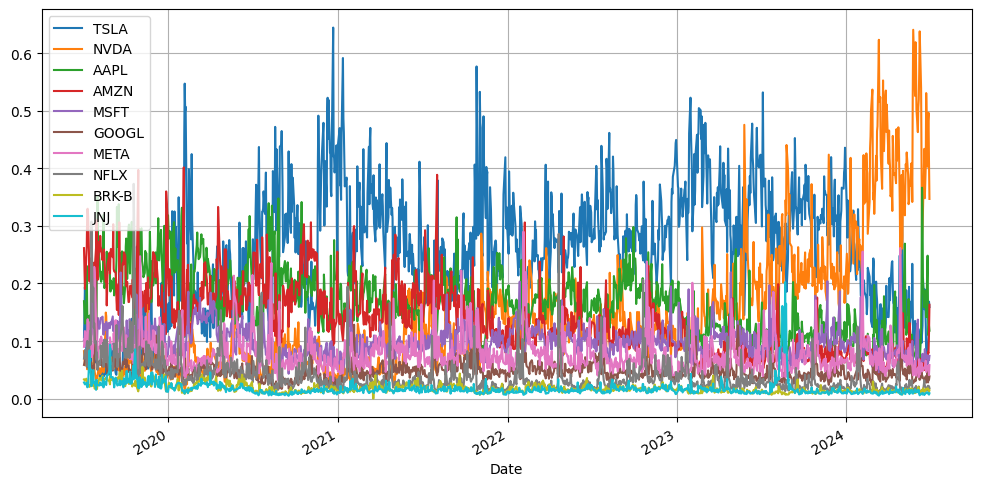

In [ ]:
import matplotlib.pyplot as plt
marketVolumeWeights.plot(figsize=(12,6))
plt.grid()

Text(0.5, 1.0, 'Portfolio: Dividend Yield Weights')

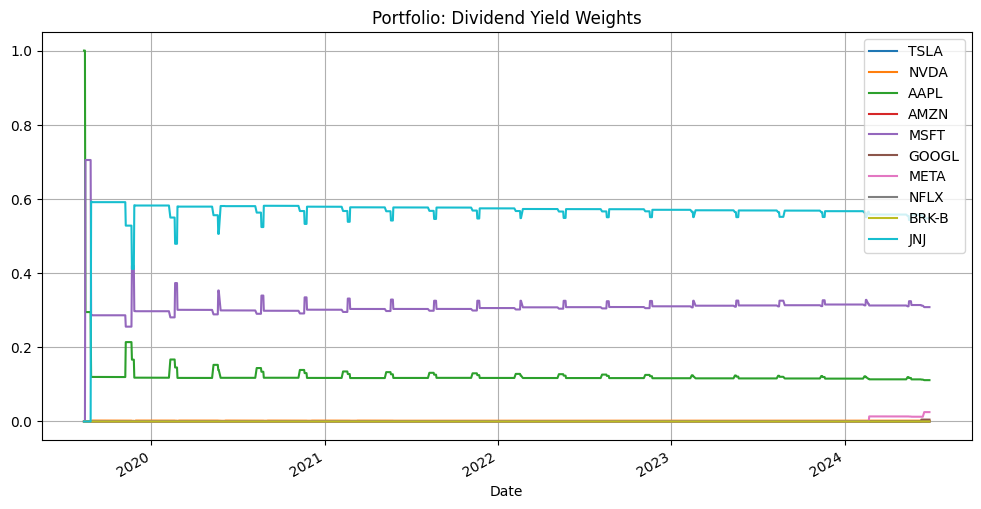

In [ ]:
def calculateDividendYieldWeights(dividends):
    # Calculate the cumulative sum of dividends
    # Cumulative sum of dividends gives the running total of dividends for each stock
    dividend_cumsum = dividends.cumsum()

    # Calculate dividend yield weights
    # Dividend yield weights are the proportion of cumulative dividends of each stock relative to the total cumulative dividends of all stocks
    dividend_yield_weights = dividend_cumsum.div(dividend_cumsum.sum(axis=1), axis=0)

    # Shift the DataFrame by one row
    # The return for the month depends on the allocation defined in the previous month
    shifted_dividend_yield_weights = dividend_yield_weights.shift(1)

    return shifted_dividend_yield_weights

dividendYieldWeights = calculateDividendYieldWeights(dividends)
dividendYieldWeights.plot(figsize=(12,6))
plt.grid()
plt.title('Portfolio: Dividend Yield Weights')

In [ ]:
# Generating and plotting the daily returns of Portfolio

def generate_returns(prices):
  return_prices = (prices / prices.shift(1)) - 1
  return return_prices

returns = generate_returns(close)
returns.tail()

,TSLA,NVDA,AAPL,AMZN,MSFT,GOOGL,META,NFLX,BRK-B,JNJ
Date,,,,,,,,,,
2024-06-24 00:00:00-04:00,-0.002350,-0.066840,0.003133,-0.018564,-0.004691,-0.002282,0.008347,-0.024923,0.010644,0.002487
2024-06-25 00:00:00-04:00,0.026126,0.067564,0.004468,0.004149,0.007327,0.026839,0.023431,0.005067,-0.007271,-0.012943
2024-06-26 00:00:00-04:00,0.048145,0.002459,0.019993,0.039015,0.002683,-0.000815,0.004935,0.007852,-0.001728,-0.002514
2024-06-27 00:00:00-04:00,0.005347,-0.019066,0.003986,0.021900,0.001526,0.008321,0.012551,0.009813,-0.005631,-0.006947
2024-06-28 00:00:00-04:00,0.002330,-0.003629,-0.016254,-0.023250,-0.013029,-0.017583,-0.029525,-0.013824,-0.002819,0.002469


Text(0.5, 1.0, 'Daily Returns')

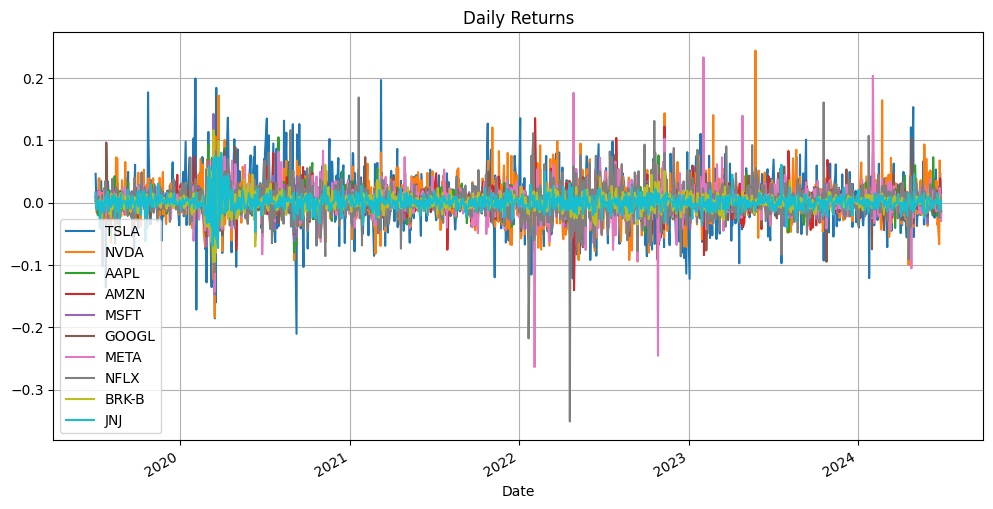

In [ ]:
returns.plot(figsize=(12,6))
plt.grid()
plt.title('Daily Returns')

Text(0.5, 1.0, 'Market Volume Weights Returns')

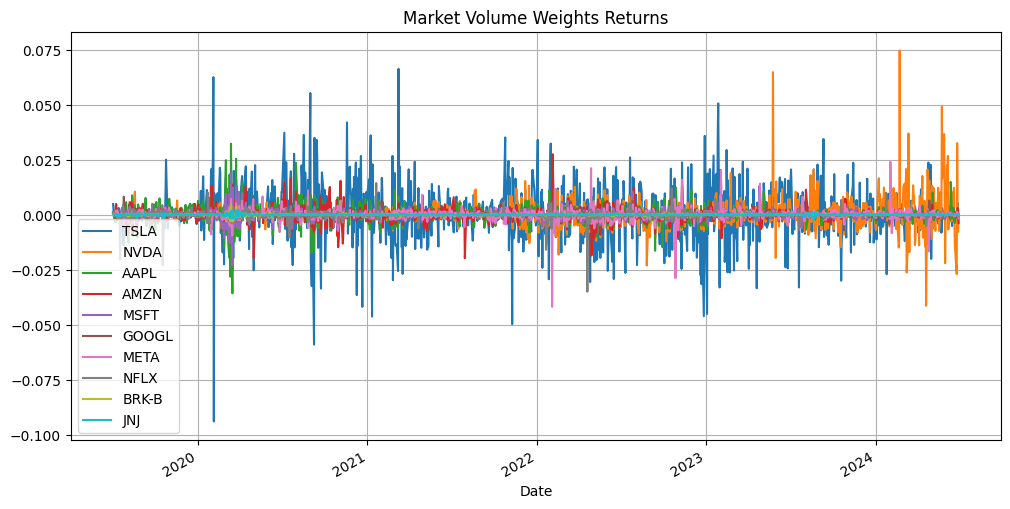

In [ ]:
# Generating and plotting the Market Volume Weights Returns
#D. Weighted Returns
def generate_weighted_returns(returns, weights):
  return returns * weights

marketVolumeWeightsReturn = generate_weighted_returns(returns, marketVolumeWeights)
dividendYieldWeightsReturns = generate_weighted_returns(returns, dividendYieldWeights)

marketVolumeWeightsReturn.plot(figsize=(12,6))
plt.grid()
plt.title('Market Volume Weights Returns')

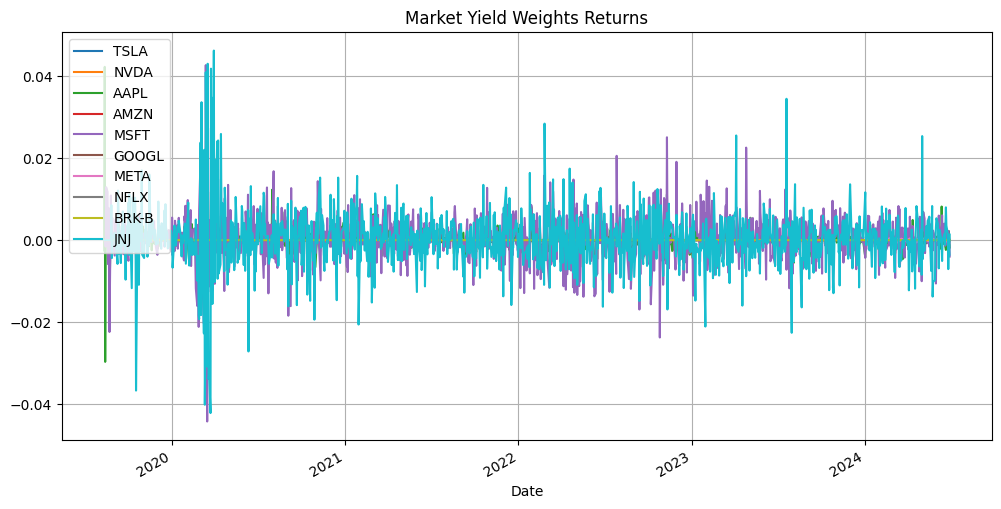

In [ ]:
# Plotting the Market Yield Weights Returns
dividendYieldWeightsReturns.plot(figsize=(12,6))
plt.grid()
plt.title('Market Yield Weights Returns')
plt.legend(loc="upper left")

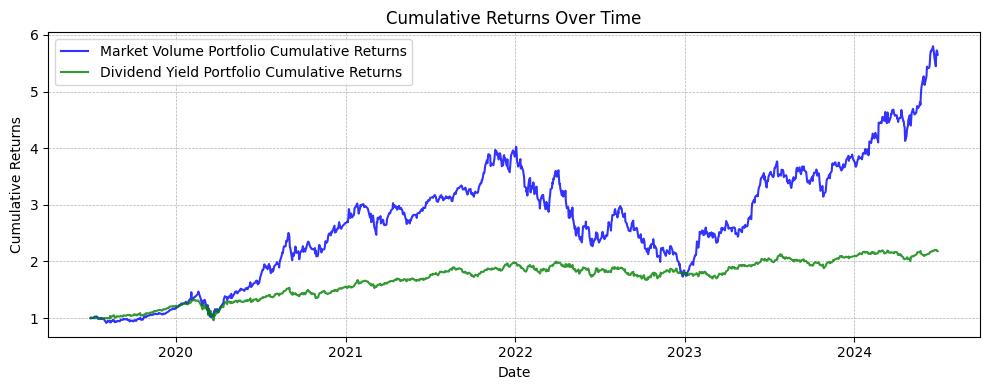

In [ ]:
# E. Cumulative Returns

def calculate_cumulative_returns(returns):
    return (1 + returns.sum(axis = 1)).cumprod()

marketVolumeWeightsCumulativeReturn = calculate_cumulative_returns(marketVolumeWeightsReturn)
dividendYieldWeightsCumulativeReturn = calculate_cumulative_returns(dividendYieldWeightsReturns)

# Plotting the cumulative returns
plt.figure(figsize=(10, 4))
plt.plot(marketVolumeWeightsCumulativeReturn, label='Market Volume Portfolio Cumulative Returns', alpha=0.8, color='blue')
plt.plot(dividendYieldWeightsCumulativeReturn, label='Dividend Yield Portfolio Cumulative Returns', alpha=0.8, color='green')
plt.title('Cumulative Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
# Portfolio Optimization (Smart Beta Strategy)
#A. Covariance matrix
def get_covariance_returns(returns):
  return np.cov(returns.T.fillna(0))

covariance_returns = get_covariance_returns(returns)
covariance_returns = pd.DataFrame(covariance_returns, returns.columns, returns.columns)

covariance_returns

,TSLA,NVDA,AAPL,AMZN,MSFT,GOOGL,META,NFLX,BRK-B,JNJ
TSLA,0.001679,0.000638,0.000402,0.000385,0.000350,0.000320,0.000380,0.000423,0.000152,0.000052
NVDA,0.000638,0.001093,0.000413,0.000433,0.000441,0.000407,0.000504,0.000456,0.000184,0.000080
AAPL,0.000402,0.000413,0.000402,0.000266,0.000286,0.000266,0.000319,0.000263,0.000152,0.000097
AMZN,0.000385,0.000433,0.000266,0.000489,0.000287,0.000288,0.000382,0.000346,0.000110,0.000059
MSFT,0.000350,0.000441,0.000286,0.000287,0.000364,0.000290,0.000332,0.000268,0.000143,0.000096
GOOGL,0.000320,0.000407,0.000266,0.000288,0.000290,0.000408,0.000362,0.000262,0.000143,0.000083
META,0.000380,0.000504,0.000319,0.000382,0.000332,0.000362,0.000784,0.000400,0.000150,0.000077
NFLX,0.000423,0.000456,0.000263,0.000346,0.000268,0.000262,0.000400,0.000838,0.000102,0.000053
BRK-B,0.000152,0.000184,0.000152,0.000110,0.000143,0.000143,0.000150,0.000102,0.000184,0.000094
JNJ,0.000052,0.000080,0.000097,0.000059,0.000096,0.000083,0.000077,0.000053,0.000094,0.000157


In [ ]:
covariance_returns.style.background_gradient(cmap='coolwarm')

,TSLA,NVDA,AAPL,AMZN,MSFT,GOOGL,META,NFLX,BRK-B,JNJ
TSLA,0.001679,0.000638,0.000402,0.000385,0.000350,0.000320,0.000380,0.000423,0.000152,0.000052
NVDA,0.000638,0.001093,0.000413,0.000433,0.000441,0.000407,0.000504,0.000456,0.000184,0.000080
AAPL,0.000402,0.000413,0.000402,0.000266,0.000286,0.000266,0.000319,0.000263,0.000152,0.000097
AMZN,0.000385,0.000433,0.000266,0.000489,0.000287,0.000288,0.000382,0.000346,0.000110,0.000059
MSFT,0.000350,0.000441,0.000286,0.000287,0.000364,0.000290,0.000332,0.000268,0.000143,0.000096
GOOGL,0.000320,0.000407,0.000266,0.000288,0.000290,0.000408,0.000362,0.000262,0.000143,0.000083
META,0.000380,0.000504,0.000319,0.000382,0.000332,0.000362,0.000784,0.000400,0.000150,0.000077
NFLX,0.000423,0.000456,0.000263,0.000346,0.000268,0.000262,0.000400,0.000838,0.000102,0.000053
BRK-B,0.000152,0.000184,0.000152,0.000110,0.000143,0.000143,0.000150,0.000102,0.000184,0.000094
JNJ,0.000052,0.000080,0.000097,0.000059,0.000096,0.000083,0.000077,0.000053,0.000094,0.000157


In [ ]:
# Importing cvxpy and invoking the weight optimization function
# !pip install cvxpy

# B. Weight Optimization
import cvxpy as cvx

def get_optimal_weights(covariance_returns, index_weights, scale=2.0):
    # Create a variable to store the portfolio weights.
    x = cvx.Variable(len(index_weights))

    # Calculate the portfolio variance using the quadratic form.
    portfolio_var = cvx.quad_form(x, covariance_returns)

    # Calculate the distance (L2 norm) between the portfolio weights and the index weights.
    dist_index = cvx.norm(x - index_weights, p=2)

    # Define the objective function: Minimize portfolio variance and distance from the index.
    objective = cvx.Minimize(portfolio_var + scale * dist_index)

    # Define the constraints: Weights should be positive and sum up to 1.
    constraints = [x >= 0, sum(x) == 1]

    # Set up the optimization problem.
    problem = cvx.Problem(objective, constraints)

    # Solve the optimization problem.
    problem.solve()

    # Return the optimal portfolio weights.
    return x.value

In [ ]:
# Rebalancing portfolio over time with chunk_size = 250 (the size of the window over which covariance is calculated) and shift_size = 5 (the number of
# periods after which the portfolio will be rebalanced)

def rebalance_portfolio(returns, index_weights, shift_size, chunk_size):
    # Initialize an empty list to store the rebalanced portfolio weights at each interval.
    all_rebalance_weights = []
    # List to store the rebalancing dates.
    rebalance_dates = []

    # Iterate through the historical data in steps of shift_size starting from chunk_size.
    for i in range(chunk_size, len(returns), shift_size):
        # Calculate the covariance matrix of returns over the chunk_size window up to the current period.
        covariance_returns = returns.iloc[i-chunk_size:i].cov()

        # Get the optimal portfolio weights using the covariance matrix and the latest index weights.
        rebalance_weights = get_optimal_weights(covariance_returns, index_weights.iloc[i-1])

        # Append the calculated optimal weights to our list.
        all_rebalance_weights.append(rebalance_weights)

        # Append the rebalance date to our dates list.
        rebalance_dates.append(returns.index[i])

    # Convert the list of optimal weights to a DataFrame with columns named after the assets.
    df_rebalance_weights = pd.DataFrame(all_rebalance_weights, columns=returns.columns)

    # Set the rebalance dates as the index of the resulting DataFrame.
    df_rebalance_weights['Date'] = rebalance_dates
    df_rebalance_weights.set_index('Date', inplace=True)

    # Return the DataFrame.
    return df_rebalance_weights

# Define the size of the window over which covariance is calculated.
chunk_size = 250

# Define the number of periods after which the portfolio will be rebalanced.
shift_size = 5

# Rebalance the portfolio
marketVolumeRebalanceWeights = rebalance_portfolio(returns, marketVolumeWeights, shift_size, chunk_size)
print(marketVolumeRebalanceWeights)

# Rebalance the portfolio
dividendYieldRebalanceWeights = rebalance_portfolio(returns, dividendYieldWeights, shift_size, chunk_size)
print(dividendYieldRebalanceWeights)

                               TSLA      NVDA      AAPL      AMZN      MSFT  \
Date                                                                          
2020-06-29 00:00:00-04:00  0.187722  0.073205  0.252019  0.168234  0.110634   
2020-07-07 00:00:00-04:00  0.276847  0.046328  0.134618  0.253044  0.077514   
2020-07-14 00:00:00-04:00  0.381689  0.055056  0.089524  0.185878  0.057177   
2020-07-21 00:00:00-04:00  0.209096  0.040443  0.129500  0.210589  0.092526   
2020-07-28 00:00:00-04:00  0.320837  0.056155  0.195792  0.197830  0.090351   
...                             ...       ...       ...       ...       ...   
2024-05-29 00:00:00-04:00  0.134939  0.525703  0.079277  0.057012  0.058586   
2024-06-05 00:00:00-04:00  0.121297  0.505849  0.097507  0.055094  0.072552   
2024-06-12 00:00:00-04:00  0.096720  0.418566  0.205496  0.070593  0.065549   
2024-06-20 00:00:00-04:00  0.189576  0.348122  0.187087  0.060368  0.085875   
2024-06-27 00:00:00-04:00  0.110321  0.496462  0.109

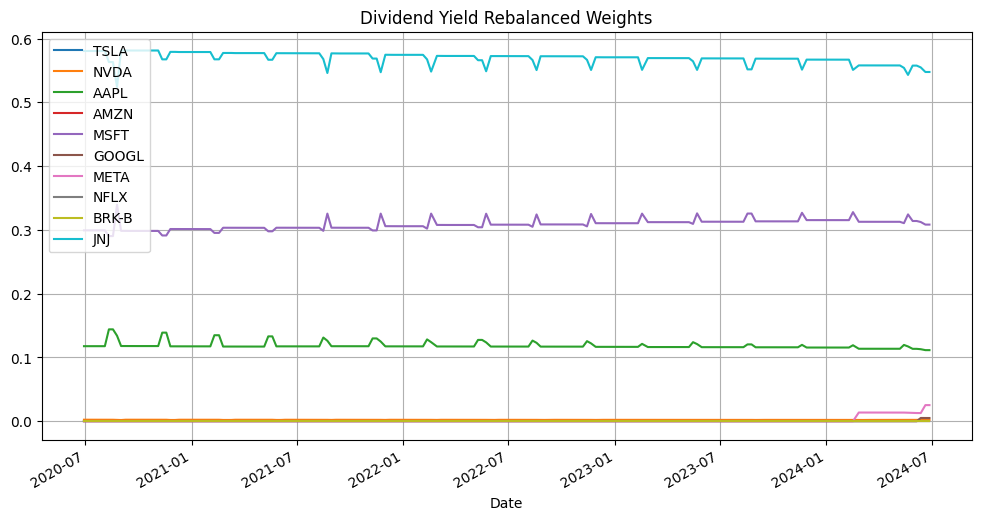

In [ ]:
# Plotting the Dividend Yield Rebalance Weights
dividendYieldRebalanceWeights.plot(figsize=(12,6))
plt.grid()
plt.title('Dividend Yield Rebalanced Weights')
plt.legend(loc="upper left")

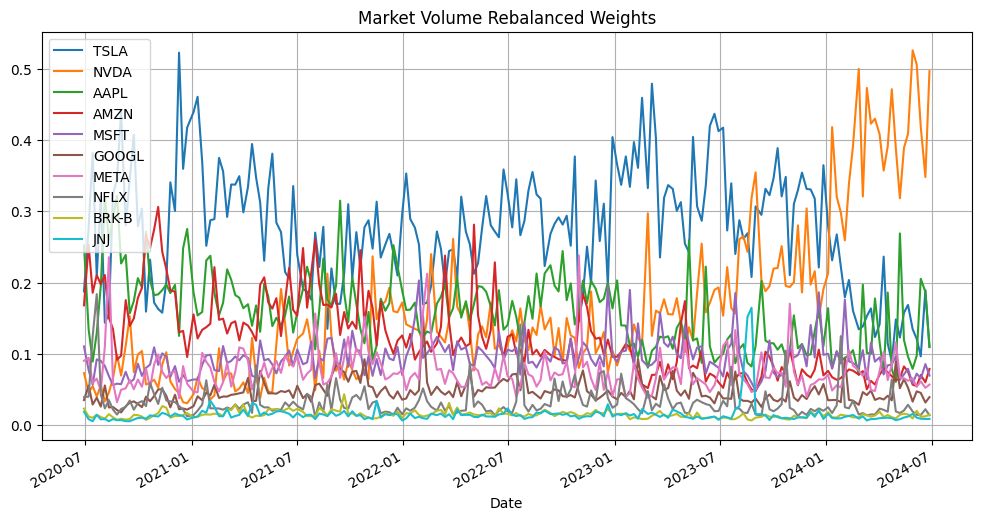

In [ ]:
#Plotting the Market Volume Rebalance Weights
marketVolumeRebalanceWeights.plot(figsize=(12,6))
plt.grid()
plt.title('Market Volume Rebalanced Weights')
plt.legend(loc="upper left")

In [ ]:
# D. Cumulative Returns Calculation
def calculate_cumulative_portfolio_returns(returns, rebalance_weights):
    # Initializing the series for portfolio returns
    portfolio_returns = pd.Series(index=returns.index)

    # Example usage of the function with example data
    n_col = len(rebalance_weights.columns)
    initial_weights = pd.Series([1/n_col] * n_col, index=rebalance_weights.columns)

    # Setting current weights to initial weights
    current_weights = initial_weights

    # Iterating through each date in the returns dataframe
    for date, daily_returns in returns.iterrows():
        if date != returns.index.min():
            # Check if there's a rebalance for this date and update weights if needed
            if date in rebalance_weights.index:
                current_weights = rebalance_weights.loc[date]

            # Calculating the daily portfolio return
            portfolio_return = (daily_returns * current_weights).sum()
            portfolio_returns[date] = portfolio_return

            # Adjusting current_weights based on daily returns
            current_weights *= (1 + daily_returns)

            # Normalizing the weights so they sum up to 1
            current_weights /= current_weights.sum()

    # Calculating cumulative portfolio returns
    cumulative_portfolio_returns = (1 + portfolio_returns).cumprod()
    return cumulative_portfolio_returns

# Calculate cumulative returns
optimized_marketVolumeWeightsCumulativeReturn = calculate_cumulative_portfolio_returns(returns, marketVolumeRebalanceWeights)
optimized_dividendYieldWeightsCumulativeReturn = calculate_cumulative_portfolio_returns(returns, dividendYieldRebalanceWeights)

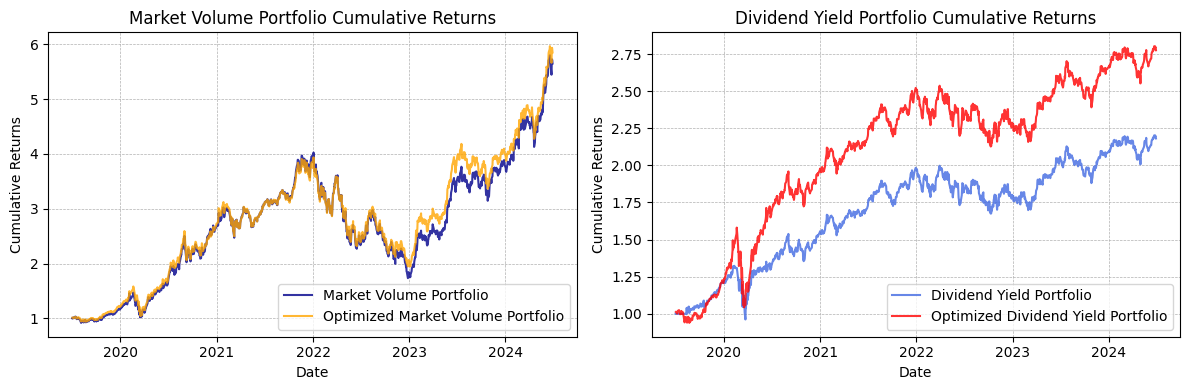

In [ ]:
# Comparing Market Volume Portfolio Cumulative Returns vs Dividend Yield Portfolio Cumulative Returns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot for Market Volume Portfolio
ax1.plot(marketVolumeWeightsCumulativeReturn, label='Market Volume Portfolio', alpha=0.8, color='darkblue')
ax1.plot(optimized_marketVolumeWeightsCumulativeReturn, label='Optimized Market Volume Portfolio', alpha=0.8, color='orange')
ax1.set_title('Market Volume Portfolio Cumulative Returns')
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Returns')
ax1.legend(loc='lower right')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot for Dividend Yield Portfolio
ax2.plot(dividendYieldWeightsCumulativeReturn, label='Dividend Yield Portfolio', alpha=0.8, color='royalblue')
ax2.plot(optimized_dividendYieldWeightsCumulativeReturn, label='Optimized Dividend Yield Portfolio', alpha=0.8, color='red')
ax2.set_title('Dividend Yield Portfolio Cumulative Returns')
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Returns')
ax2.legend(loc='lower right')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

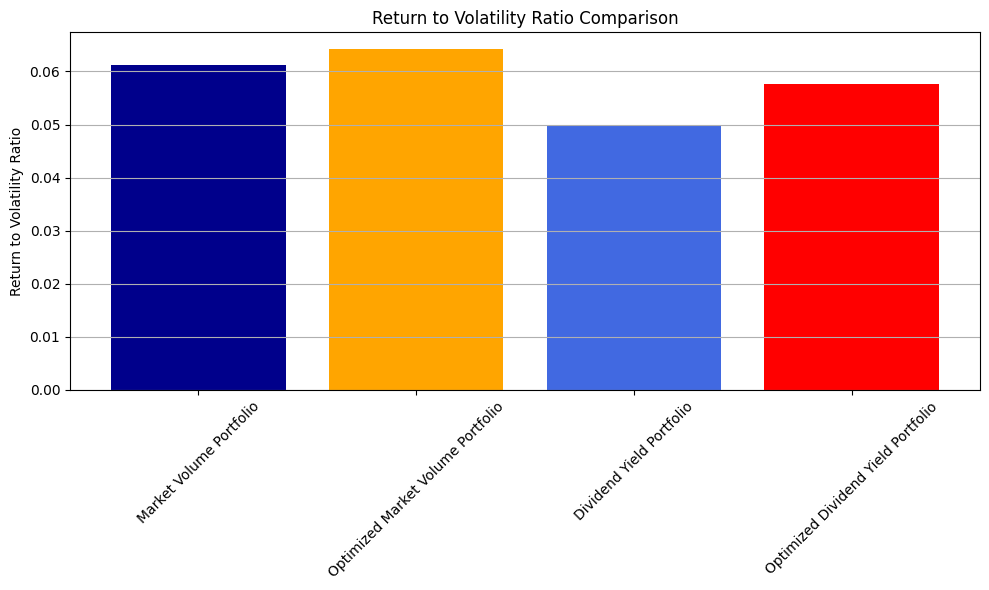

In [ ]:
# Comparing the Return/Volatility Ratios before/after PO: Market Volume Portfolio vs Dividend Yield Portfolio

# E. Return to Volatility Ratio
def return_to_volatility_ratio(portfolio_returns):
    mean_return = portfolio_returns.mean()
    std_return = portfolio_returns.std()
    ratio = mean_return / std_return
    return ratio

# Calculating return_to_volatility_ratio for each portfolio
ratios = {
    'Market Volume Portfolio': return_to_volatility_ratio(marketVolumeWeightsCumulativeReturn.diff().dropna()),
    'Optimized Market Volume Portfolio': return_to_volatility_ratio(optimized_marketVolumeWeightsCumulativeReturn.diff().dropna()),
    'Dividend Yield Portfolio': return_to_volatility_ratio(dividendYieldWeightsCumulativeReturn.diff().dropna()),
    'Optimized Dividend Yield Portfolio': return_to_volatility_ratio(optimized_dividendYieldWeightsCumulativeReturn.diff().dropna())
}

# Plotting the return to volatility ratios
plt.figure(figsize=(10, 6))
plt.bar(ratios.keys(), ratios.values(), color=['darkblue', 'orange', 'royalblue', 'red'])
plt.title('Return to Volatility Ratio Comparison')
plt.ylabel('Return to Volatility Ratio')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()